# Телеком


# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Содержание:
- [Исследовательский анализ данных](#Исследовательский-анализ-данных)
  - [Объединение таблиц и исправление типов данных](#Объединение-таблиц-и-исправление-типов-данных)
  - [Целевой признак и графики распределения](#Целевой-признак-и-графики-распределения)
  - [Выводы:](#Выводы:)
- [Подготовка данных к обучению моделей](#Подготовка-данных-к-обучению-моделей)
- [Обучение моделей](#Обучение-моделей)
- [Анализ результатов](#Анализ-результатов)
- [Выводы по проекту:](#Выводы-по-проекту:)

# Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_curve, precision_score, accuracy_score, roc_auc_score, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv') 

In [3]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [4]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
contract.head() #информация о договоре

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


* customerID - идентификационный номер клиента
* BeginDate - дата подключения клиента
* EndDate - дата отключения клиента
* Type - тип оплаты за связь
* PaperlessBilling - без бумажных квитанций
* PaymentMethod	- метод оплаты
* MonthlyCharges - стоимость связи за месяц
* TotalCharges - сумма оплаты всего за все время подключения клиента

In [7]:
personal.head() #персональные данные клиента

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


* gender - пол
* SeniorCitizen	- пенсионер/не пенсионер
* Partner - свободные/женатые	
* Dependents - зависимые(дети)/независимые

In [8]:
internet.head() #информация об интернет-услугах

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


* InternetService - подключение: цифровая абонентская линия или оптоволоконный кабель
* OnlineSecurity - блокировка небезопасных сайтов 
* OnlineBackup - Облачное хранилище файлов для резервного копирования данных
* DeviceProtection - наличие/отсутствие онлайн антивируса
* TechSupport - Выделенная линия технической поддержки
* StreamingTV - Стриминговое телевидение
* StreamingMovies - каталог фильмов

In [9]:
phone.head() #информация об услугах телефонии

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


* MultipleLines - подключение телефонного аппарата к нескольким линиям одновременно.

## Объединение таблиц и исправление типов данных

**Объединяем все таблицы в одну по customerID**

In [10]:
df = contract.set_index('customerID').join(personal.set_index('customerID'))

In [11]:
df = df.join(internet.set_index('customerID'))

In [12]:
df = df.join(phone.set_index('customerID'))

In [13]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [14]:
df.isna().sum() 

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [15]:
df[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'MultipleLines']] = df[['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                                                              'DeviceProtection', 'TechSupport', 
                                                             'StreamingTV', 'StreamingMovies', 'MultipleLines']].fillna('No')

**Так как в специфических услугах много пропусков, можно предположить, что это означает их отсутствие, поэтому заполняю пропуски значением No**

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

In [17]:
#приводим к числовому типу с принудительным исправление ошибок
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 

In [18]:
#чтобы данные были одинокового типа заменяем невыбывших клиентов датой, на которую актуален датасет
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')

In [19]:
df['EndDate'] = pd.to_datetime(df['EndDate'],format='%Y-%m-%d')

In [20]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'],format='%Y-%m-%d')

In [21]:
# формируем новый признак - количество дней, которое действовал контракт
df['duration_days'] = (df['EndDate'] - df['BeginDate']).astype('timedelta64[D]')
df['duration_days'] = df['duration_days'].astype('int')

In [22]:
df['duration_days']

customerID
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK      61
7795-CFOCW    1371
9237-HQITU      61
              ... 
6840-RESVB     730
2234-XADUH    2191
4801-JZAZL     337
8361-LTMKD     123
3186-AJIEK    2010
Name: duration_days, Length: 7043, dtype: int64

**Некоторые данные имеют неподходящий тип, исправляем. Также формируем дополнительный признак - количество дней, которое клиент был абонентом данной компании**

In [23]:
def binary_values(column):
    '''Функция меняет бинарные значения на 0/1'''
    column = np.where(column == 'No', 0, 1)
    return column


In [24]:
df['Partner'] = binary_values(df['Partner'])
df['PaperlessBilling'] = binary_values(df['PaperlessBilling'])
df['Dependents'] = binary_values(df['Dependents'])
df['OnlineSecurity'] = binary_values(df['OnlineSecurity'])
df['OnlineBackup'] = binary_values(df['OnlineBackup'])
df['DeviceProtection'] = binary_values(df['DeviceProtection'])
df['TechSupport'] = binary_values(df['TechSupport'])
df['StreamingTV'] = binary_values(df['StreamingTV'])
df['StreamingMovies'] = binary_values(df['StreamingMovies'])
df['MultipleLines'] = binary_values(df['MultipleLines'])


In [25]:
#формируем целевой признак - все те даты в столбце EndDate, что отличаются от актуальной, отмечаем 1(клиент ушел)
df['loss'] = np.where(df['EndDate'] == '2020-02-01', 0, 1)

In [26]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration_days,loss
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,...,DSL,0,1,0,0,0,0,0,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,Male,0,0,...,DSL,1,0,1,0,0,0,0,1036,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,...,DSL,1,1,0,0,0,0,0,61,1
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,...,DSL,1,0,1,1,0,0,0,1371,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,...,Fiber optic,0,0,0,0,0,0,0,61,1


In [27]:
#определяем клиентов, которые только пришли - целых 11 человек
new_clients = df[df['duration_days'] == 0].index
df.loc[new_clients]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration_days,loss
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,Female,0,1,...,DSL,1,0,1,1,1,0,0,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,Male,0,0,...,No,0,0,0,0,0,0,0,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,Female,0,1,...,DSL,1,1,1,0,1,1,0,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,NaN,Male,0,1,...,No,0,0,0,0,0,0,1,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,NaN,Female,0,1,...,DSL,1,1,1,1,1,0,0,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,NaN,Male,0,1,...,No,0,0,0,0,0,0,0,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,NaN,Male,0,1,...,No,0,0,0,0,0,0,1,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,NaN,Female,0,1,...,No,0,0,0,0,0,0,0,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,NaN,Male,0,1,...,No,0,0,0,0,0,0,0,0,0


## Целевой признак и графики распределения

In [28]:
#так как у новых клиентов еще не успел сформироваться столбец TotalCharges, то заполняем эти пропуски данными MonthlyCharges
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

In [29]:
def plotting_features(column, figsize, hue, title):
    '''Функция принимает на вход значение столбеца, размер, значение и заголовок и формирует график
    распределения признаков в связке с ушедшими/оставшимися клиентами '''
    plt.figure(figsize=(figsize))
    sns.countplot(x = column, hue=hue)
    plt.title(title)
    plt.xlabel('Варианты') 
    plt.ylabel('Частота')
    plt.show()

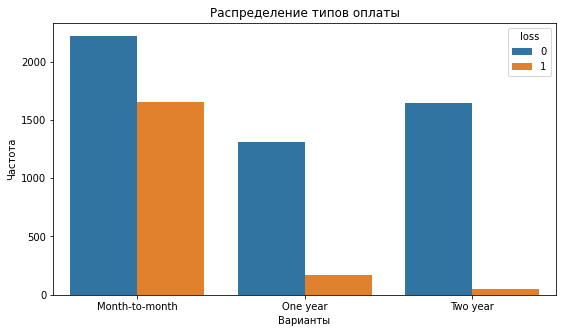

In [30]:
plotting_features(df['Type'], (9, 5), df['loss'], 'Распределение типов оплаты')

Клиентов, которые оплачивают счет за связь ежемесячно, больше. И их отток тоже больше всего. Чем больший период оплачивает клиент сразу, тем менее охотно он меняет провайдера.

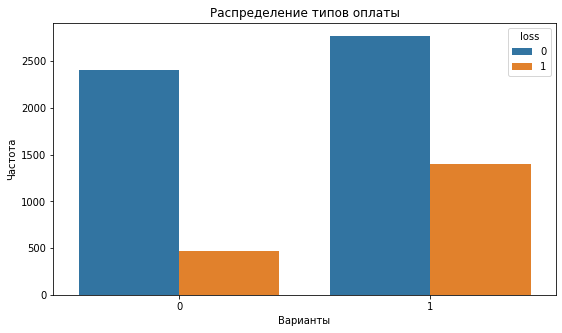

In [31]:
plotting_features(df['PaperlessBilling'], (9,5), df['loss'], 'Распределение типов оплаты')

Клиенты, которые отказались от бумажных счетов за связь уходят от провайдера больше. Или их отключают за неуплату, так как без бумажных счетов сложнее помнить о сроках оплаты? Возможно, стоит проработать вопрос о периодических напоминаниях об оплате.

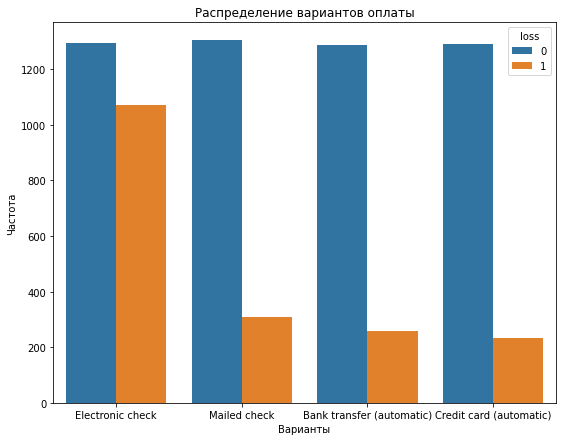

In [32]:
plotting_features(df['PaymentMethod'], (9, 7), df['loss'], 'Распределение вариантов оплаты')

Клиенты по вариантам оплаты разделились примерно одинаково. Клиенты, выбравшие автоплатежи с карты или счета, уходят меньше.
А по электронному платежу самый высокий показатель. Вероятно, какие-то технические проблемы с этой системой платежа не устраивают клиентов. 

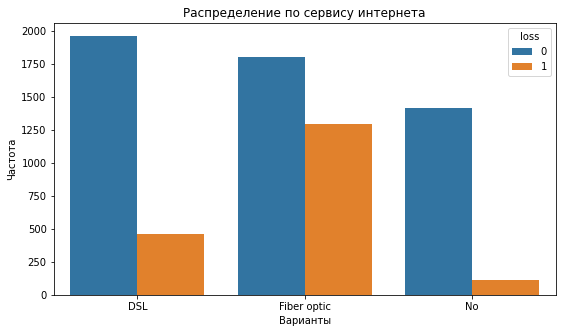

In [33]:
plotting_features(df['InternetService'], (9,5), df['loss'], 'Распределение по сервису интернета')

У тех, у кого нет интернета реже уходят от провайдера. Возможно, в качестве или стоимости интернета кроются причины оттока. Самый высокий показатель оттока у клиентов с оптоволоконным кабелем. Проанализировать бы обращения в техподдержку по этому вопросу.

In [34]:
df['duration_days'].value_counts().sort_index()

0        11
30      182
31      431
61      123
62      115
       ... 
2132    112
2160      5
2161      1
2163    164
2191    362
Name: duration_days, Length: 156, dtype: int64

In [35]:
#категоризируем данные по длительности контракта
df['duration_days_category'] = pd.cut(df['duration_days'], [-np.inf, 31, 181, 365, 720, 1095, 2191], 
                                      labels=['month','half_year', 'year', 'two_years', 'three_years', 'more'])


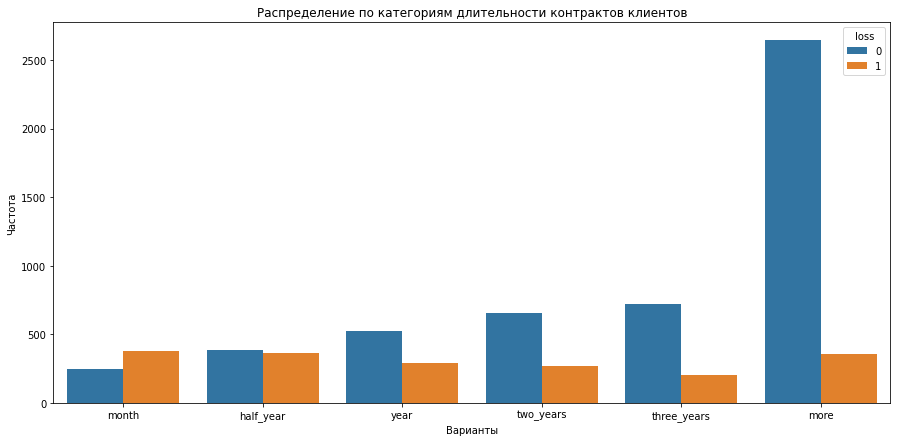

In [36]:
plotting_features(df['duration_days_category'], (15, 7), df['loss'], 'Распределение по категориям длительности контрактов клиентов')

Наибольший отток клиентов наблюдается в первый месяц пользования услугами. Высокий уровень оттока сохраняется и в течение первых 6 месяцев.

In [37]:
df['TotalCharges'].value_counts().sort_index()

18.80      1
18.85      2
18.90      1
19.00      1
19.05      1
          ..
8564.75    1
8594.40    1
8670.10    1
8672.45    1
8684.80    1
Name: TotalCharges, Length: 6534, dtype: int64

In [38]:
#категоризируем данные по общей сумме оплаты
df['TotalCharges_category'] = pd.cut(df['TotalCharges'], [-np.inf, 50, 100, 500, 1000, 2000, 3000, 5000, 8684.8], 
                                      labels=['50$', '100$', '500$', '1000$', '2000$', '3000$', '5000$', 'more'])

In [39]:
df['TotalCharges_category'].value_counts().sort_index()

50$       371
100$      453
500$     1187
1000$     893
2000$    1283
3000$     652
5000$    1069
more     1135
Name: TotalCharges_category, dtype: int64

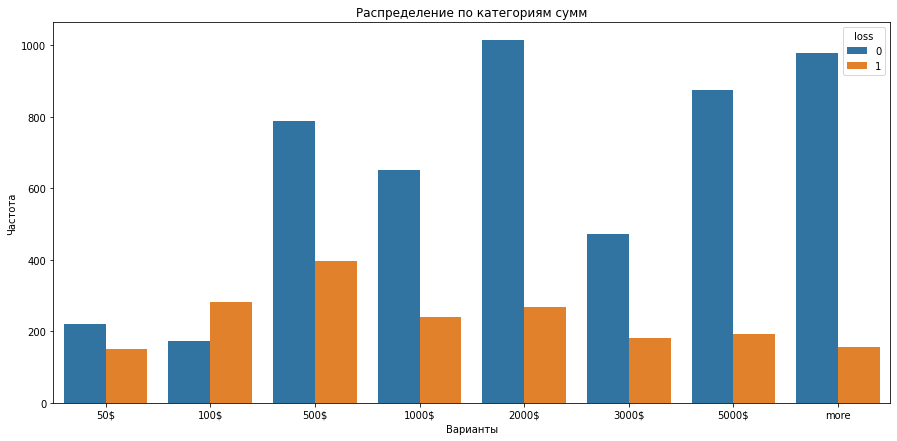

In [40]:
plotting_features(df['TotalCharges_category'], (15, 7), df['loss'], 'Распределение по категориям сумм')

Для многих счет от 50 до 100 долларов является поводом сменить провайдера. Также высокий показатель оттока у клиентов со счетами до 500 и до 50 долларов. Меньше всего уходят клиенты с суммами свыше 5000 долларов. Скорее всего, это давние клиенты. Вероятно, для них действуют специальные условия ояльности.

## Выводы:

* данные загружены и объединены в таблицу
* заполнены пропуски
* изменены типы данных
* исправлены бинарные признаки на значения 0/1
* выделен целевой признак - ушел клиент или остался
* построены графики распределения признаков 
* категоризированы признаки
* портрет клиента, готового уйти: оплачивает свзь ежемесячно без бумажного счета с помощью электронной системы, пользуется оптоволоконным интернетом. С большой частотой уходят в первый месяц пользования связью, получающие счета в пределах 100 долларов.

# Подготовка данных к обучению моделей

Планирую закодировать категориальные признаки, масштабировать признаки, удалить признаки, которые дублируются(категоризированные), разделить выборку на обучающую и тестовую

In [41]:
df = df.drop(['TotalCharges_category', 'duration_days_category', 'BeginDate', 'EndDate'], axis=1)

In [42]:
df.corr()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration_days,loss
PaperlessBilling,1.000000,0.352150,0.158562,0.156530,-0.014877,-0.111377,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.163530,0.006059,0.191825
MonthlyCharges,0.352150,1.000000,0.651182,0.220173,0.096848,-0.113890,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.490434,0.247754,0.193356
TotalCharges,0.158562,0.651182,1.000000,0.102997,0.317532,0.062124,0.411679,0.509256,0.522012,0.431910,0.514999,0.520124,0.468516,0.826095,-0.198347
SeniorCitizen,0.156530,0.220173,0.102997,1.000000,0.016479,-0.211185,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.142948,0.016514,0.150889
Partner,-0.014877,0.096848,0.317532,0.016479,1.000000,0.452676,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.142057,0.379709,-0.150448
Dependents,-0.111377,-0.113890,0.062124,-0.211185,0.452676,1.000000,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,-0.024526,0.159766,-0.164221
OnlineSecurity,-0.003636,0.296594,0.411679,-0.038653,0.143106,0.080972,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,0.098108,0.327203,-0.171226
OnlineBackup,0.126735,0.441780,0.509256,0.066572,0.141498,0.023671,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,0.202237,0.360238,-0.082255
DeviceProtection,0.103797,0.482692,0.522012,0.059428,0.153786,0.013963,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,0.201137,0.360602,-0.066160
TechSupport,0.037880,0.338304,0.431910,-0.060625,0.119999,0.063268,0.354931,0.294233,0.333313,1.000000,0.278070,0.279358,0.100571,0.324238,-0.164674


In [43]:
#удалены коррелирующие признаки
df = df.drop(['TotalCharges'], axis=1)

In [44]:
# приводим категориальные признаки в численный вид методом ОНЕ, подходящим для целей классификации
df_ohe = pd.get_dummies(df, drop_first=True)

In [45]:
df_ohe.head()

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,duration_days,loss,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.85,0,1,0,0,1,0,0,0,...,31,0,0,0,0,1,0,0,0,0
5575-GNVDE,0,56.95,0,0,0,1,0,1,0,0,...,1036,0,1,0,0,0,1,1,0,0
3668-QPYBK,1,53.85,0,0,0,1,1,0,0,0,...,61,1,0,0,0,0,1,1,0,0
7795-CFOCW,0,42.30,0,0,0,1,0,1,1,0,...,1371,0,1,0,0,0,0,1,0,0
9237-HQITU,1,70.70,0,0,0,0,0,0,0,0,...,61,1,0,0,0,1,0,0,1,0


In [46]:
# отделяем целевой признак
features = df_ohe.drop(['loss'], axis=1)
target = df_ohe['loss']

In [47]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345
)

In [48]:
print(features_test.shape, target_test.shape)

(1409, 21) (1409,)


In [49]:
 # преобразуем масштаб методом стандартизации
scaler = StandardScaler()
numeric =['MonthlyCharges', 'duration_days']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


/tmp/ipykernel_118/2030367726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_118/2030367726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [50]:
df_ohe['loss'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: loss, dtype: float64

Подсчет классов в целевом признаке выявляет проблему несбалансированных данных. Объектов класса "1" меньше почти в три раза.

In [51]:
def upsample(features, target, repeat):
    '''функция делит признаки на классы и увеличивает класс "1" в заданное количество раз(repeat)'''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled    

In [52]:
#увеличение выборки
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [53]:
target_upsampled.value_counts(normalize=True)

1    0.518923
0    0.481077
Name: loss, dtype: float64

Данные сбалансированы.

**Выводы:**
* удалены некоторые признаки: задвоенные категоризацией и не влияющие на результат
* удалены признаки с сильной корреляцией
* категориальные и численные признаки закодированы
* сбалансированы признаки в обучающей выборке

# Обучение моделей

Обучение нескольких моделей и проверка на тестовой выборке

In [54]:
def model_scoring(model):
    pred_proba_test = model.predict_proba(features_test)[:, 1]
    pred_test = model.predict(features_test)
    report = classification_report(target_test, pred_test, target_names=['Non-churned', 'Churned'])
    #print('Accuracy:', accuracy_score(target_test, pred_test))
    print('AUC-ROC:', round(roc_auc_score(target_test, pred_proba_test), 3))
    print(report)
    fpr, tpr, thresholds = roc_curve(target_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()
   


In [55]:
def features_importance(model, train_features):
    importances = model.best_estimator_.feature_importances_
    feature_list = list(train_features.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(16,14))
    fig.set_size_inches(35,15)
    sns.barplot(x='importance', y='feature', data=feature_results)
    plt.title("Важность признаков")
    plt.ylabel('Признаки')
    plt.xlabel('Важность')
    fig.tight_layout()
       
    display(plt.show())
    print('5 важных признаков', feature_results.head())
    print('5 несущественных признаков', feature_results.tail())


### LogisticRegression

In [56]:
model_lr = LogisticRegression(random_state=12345, n_jobs=-1, C=4)
model_lr.fit(features_upsampled, target_upsampled)

LogisticRegression(C=4, n_jobs=-1, random_state=12345)

AUC-ROC: 0.844
              precision    recall  f1-score   support

 Non-churned       0.91      0.72      0.80      1030
     Churned       0.52      0.81      0.63       379

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409



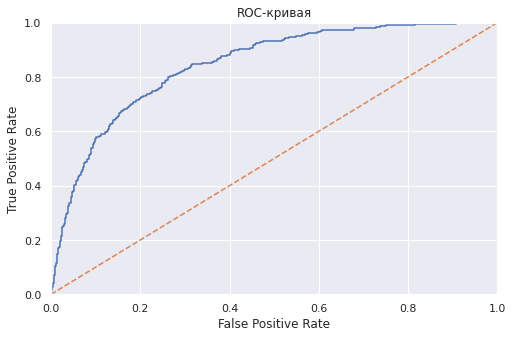

In [57]:
model_scoring(model_lr)

### RandomForestClassifier

In [58]:
%%time
param_grid =  {'n_estimators': [10, 70, 500, 1000],
              'max_depth': [None, 13, 20, 50],
              #'min_samples_leaf': range(1, 7, 2),
              #'min_samples_split': range(2, 8,2)
             }

model_forest = RandomForestClassifier(random_state=12345)
model = GridSearchCV(model_forest, param_grid=param_grid,
                               cv = 4, n_jobs = -1)
model.fit(features_upsampled, target_upsampled)


CPU times: user 2min 18s, sys: 2.73 s, total: 2min 20s
Wall time: 2min 21s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [None, 13, 20, 50],
                         'n_estimators': [10, 70, 500, 1000]})

In [59]:
model.best_params_

{'max_depth': None, 'n_estimators': 1000}

AUC-ROC: 0.836
              precision    recall  f1-score   support

 Non-churned       0.85      0.87      0.86      1030
     Churned       0.62      0.58      0.60       379

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409



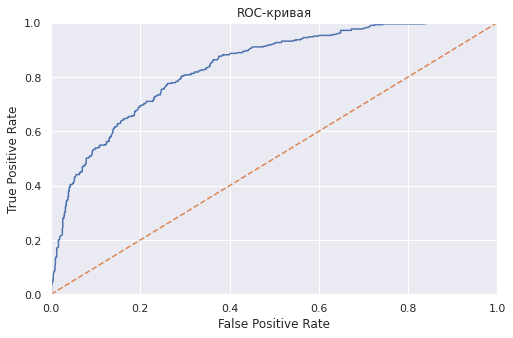

In [60]:
model_scoring(model)

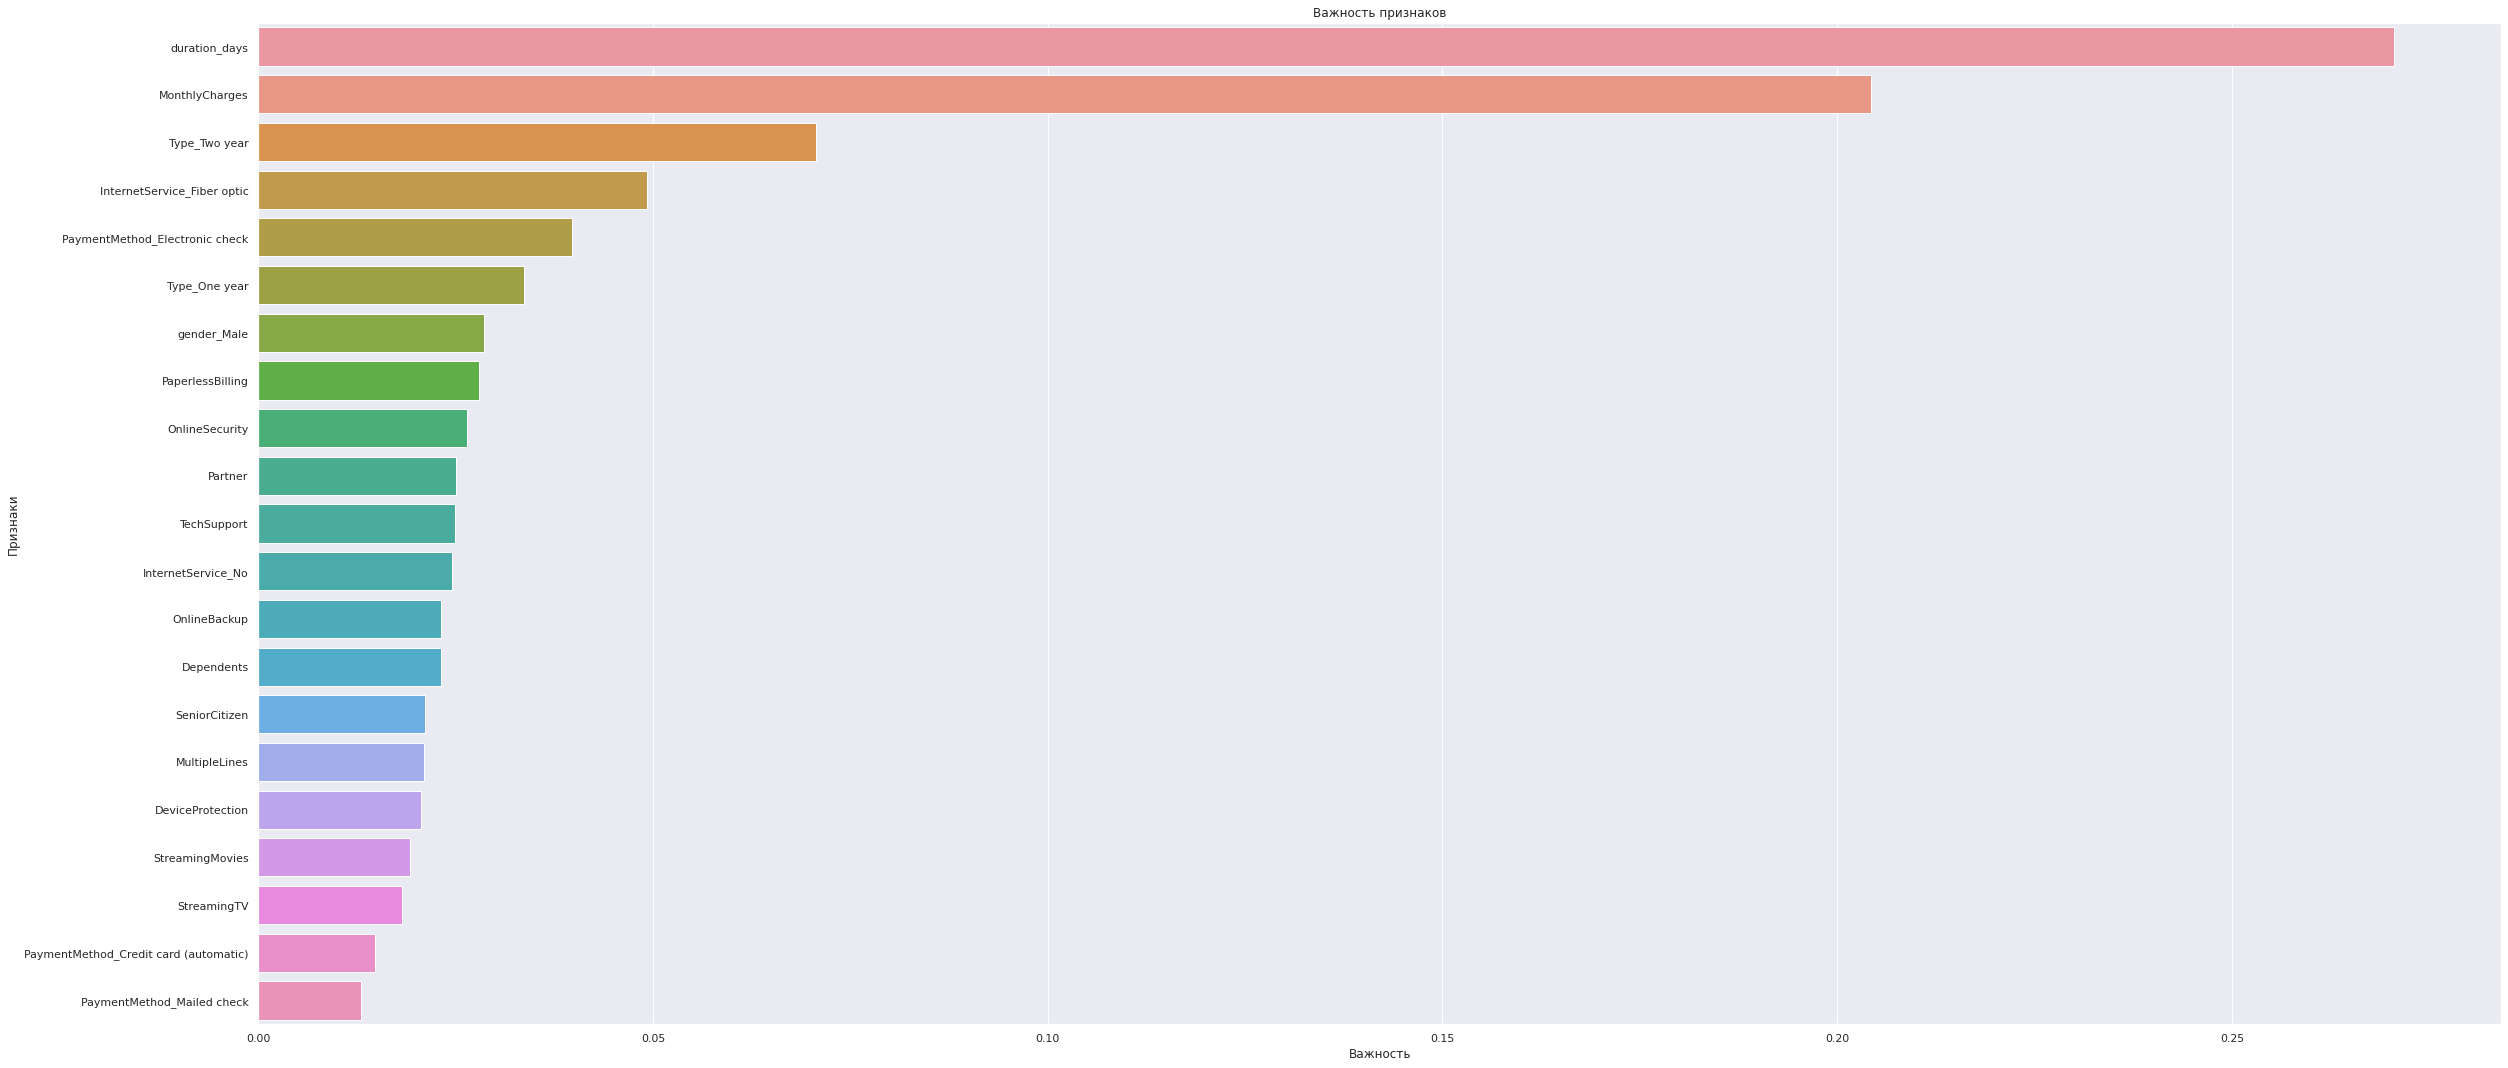

None

5 важных признаков                           feature  importance
0                   duration_days    0.270592
1                  MonthlyCharges    0.204296
2                   Type_Two year    0.070631
3     InternetService_Fiber optic    0.049256
4  PaymentMethod_Electronic check    0.039708
5 несущественных признаков                                   feature  importance
16                       DeviceProtection    0.020604
17                        StreamingMovies    0.019217
18                            StreamingTV    0.018178
19  PaymentMethod_Credit card (automatic)    0.014772
20             PaymentMethod_Mailed check    0.012975


In [61]:
features_importance(model, features_upsampled)

### CatBoostClassifier

In [62]:
%%time

CatBoost_param = {'n_estimators': [500, 1000],
                      'learning_rate': [0.01, 0.1],
                      'max_depth': [12, 15],
                      #'l2_leaf_reg': [1, 3]
                 }
CatBoost_clf = CatBoostClassifier(random_state=12345, verbose=0)
model_cat = GridSearchCV(CatBoost_clf, param_grid=CatBoost_param,
                               cv = 4, n_jobs = -1)
model_cat.fit(features_upsampled, target_upsampled)

CPU times: user 2h 8min 32s, sys: 1h 5min 36s, total: 3h 14min 9s
Wall time: 3h 15min 6s


GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fbe74d90e80>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [12, 15],
                         'n_estimators': [500, 1000]})

In [63]:
model_cat.best_params_

{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 1000}

AUC-ROC: 0.87
              precision    recall  f1-score   support

 Non-churned       0.87      0.90      0.88      1030
     Churned       0.69      0.62      0.65       379

    accuracy                           0.82      1409
   macro avg       0.78      0.76      0.77      1409
weighted avg       0.82      0.82      0.82      1409



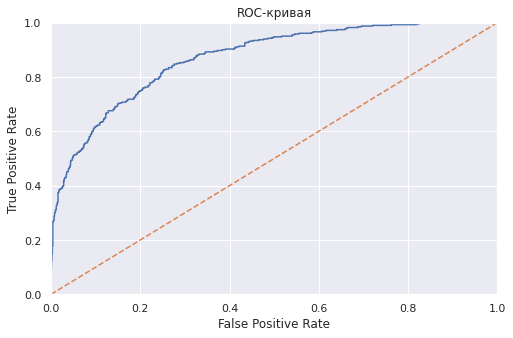

In [64]:
model_scoring(model_cat)

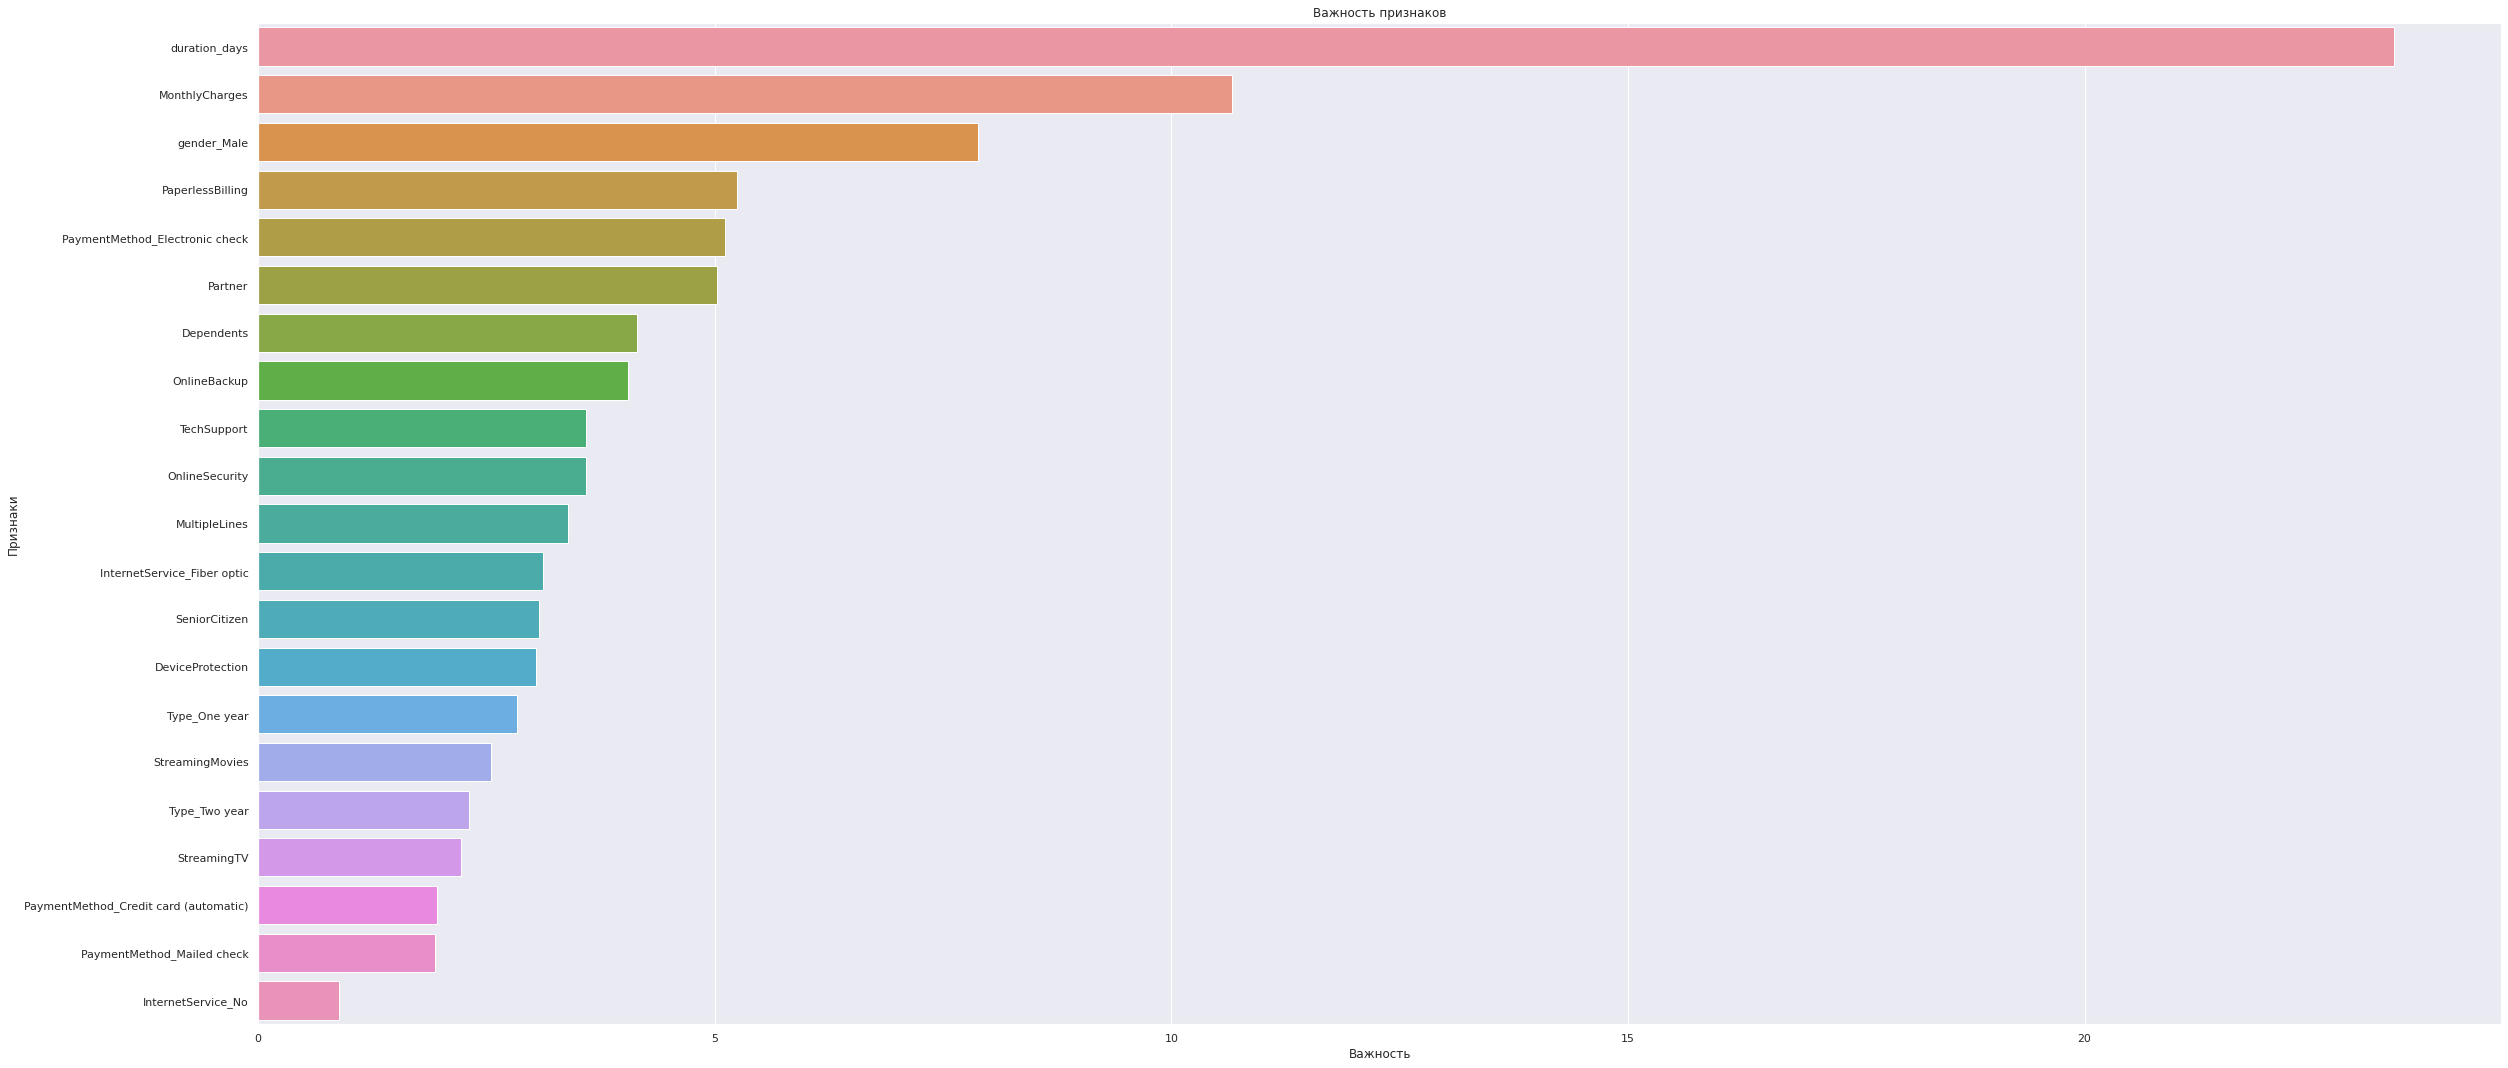

None

5 важных признаков                           feature  importance
0                   duration_days   23.393594
1                  MonthlyCharges   10.658808
2                     gender_Male    7.877091
3                PaperlessBilling    5.246132
4  PaymentMethod_Electronic check    5.109965
5 несущественных признаков                                   feature  importance
16                          Type_Two year    2.309537
17                            StreamingTV    2.220701
18  PaymentMethod_Credit card (automatic)    1.960418
19             PaymentMethod_Mailed check    1.937438
20                     InternetService_No    0.880558


In [65]:
features_importance(model_cat, features_upsampled)

### LGBMClassifier

In [66]:
%%time

model_lgbm = LGBMClassifier(random_state=12345, n_jobs = -1, 
                            max_depth=15, n_estimators=1000, learning_rate=0.1)

model_lgbm.fit(features_upsampled, target_upsampled)

CPU times: user 4min 43s, sys: 5.27 s, total: 4min 48s
Wall time: 4min 51s


LGBMClassifier(max_depth=15, n_estimators=1000, random_state=12345)

AUC-ROC: 0.915
              precision    recall  f1-score   support

 Non-churned       0.90      0.91      0.91      1030
     Churned       0.75      0.72      0.73       379

    accuracy                           0.86      1409
   macro avg       0.82      0.81      0.82      1409
weighted avg       0.86      0.86      0.86      1409



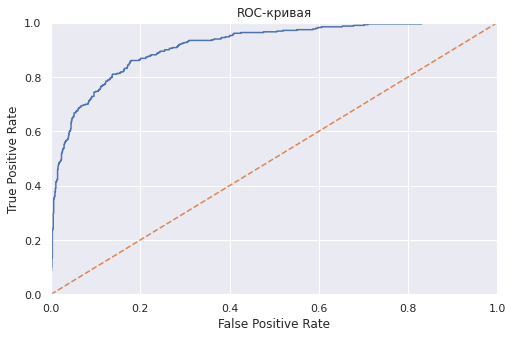

In [69]:
model_scoring(model_lgbm)

* ROC-кривая по горизонтали доля ложноположительных ответов (FPR), а по вертикали — доля истинно положительных ответов (TPR). Чем график выше, тем больше значение TPR и лучше качество модели.
* AUC-ROC (или ROC AUC) — площадь под кривой ошибок. В идеальном случае, когда классификатор не делает ошибок площадь под кривой равна единице. И наоборот, когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к 0.5 
* Accuracy - доля правильных ответов алгоритма
* Precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными.
* Recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.
* F1-мера достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

Важность и неважность признаков у разных моделей разная. Причем, некоторые признаки важны у одной модели, а у другой входят в пятерку самых неважных.

# Анализ результатов

Сделать сравнительную таблицу, проанализировать результаты и сделать выводы.

In [72]:
data = {'Модель':['LogisticRegression','RandomForestClassifier', 'CatBoostClassifier', 
                  'LGBMClassifier'], 
        'Presicion': [0.71, 0.73, 0.78, 0.82],
        'Recall': [0.77, 0.72, 0.76, 0.81],
        'Accuracy':[0.74, 0.79, 0.82, 0.86],
        'f1-score':[0.72, 0.73, 0.77, 0.82],
        'AUC-ROC': [0.844, 0.836, 0.87, 0.915],
        'Скорость обучения': ['0 min', '2min 21s', '3h 15min', '4min 51s']}

pd.DataFrame(data)

,Модель,Presicion,Recall,Accuracy,f1-score,AUC-ROC,Скорость обучения
0,LogisticRegression,0.71,0.77,0.74,0.72,0.844,0 min
1,RandomForestClassifier,0.73,0.72,0.79,0.73,0.836,2min 21s
2,CatBoostClassifier,0.78,0.76,0.82,0.77,0.870,3h 15min
3,LGBMClassifier,0.82,0.81,0.86,0.82,0.915,4min 51s


* LogisticRegression требует совсем немного времени на обучение, но метрика у нее не самая большая.
* RandomForestClassifier результат показал совсем немного хуже логистической регрессии.
* CatBoostClassifier показала неплохой результат по заданной метрике 
* LGBMClassifier показала самую лучшую метрику и приемлемое время обучения

# Выводы по проекту:

* данные объединены в таблицу
* заполнены пропуски и  изменены типы данных
* исправлены бинарные признаки на значения 0/1
* выделен целевой признак - ушел клиент или остался
* построены графики распределения признаков 
* сбалансированы признаки в обучающей выборке
* обучены разные модели и построены ROC-кривые
* LGBMClassifier показала хороший результат. И времени на обучение требуется не много.
* Таким образом, данная модель может использоваться для прогнозирования оттока клиентов - с вероятностью 86% (Accuracy - 0.86) она будет правильно предсказывать клиентов, планирующий расторгнуть контракт на услуги связи.

[Наверх](#Содержание:)